# ACO Results Public Use Data

This notebook consilolidates the 2013-2017 [CMS Medicare Shared Savings Program Public Use Files](https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/sharedsavingsprogram/program-data.html) for analysis and calculates the number of organizations that earned shared savings bonus in each year. 

In [1]:
#%%
import pandas as pd
from pathlib import Path
import numpy as np 
import sys
import altair as alt
import chart_theme

# register the custom theme under a chosen name
alt.themes.register('la-times', chart_theme.data_theme)

# enable the newly registered theme
alt.themes.enable('la-times')


ThemeRegistry.enable('la-times')

## Merging the data
In the cell below, we bring the files together and rename some columns to get a consistent layout. 

Note the variable: 

```
interesting_columns = ['year','ACO_Name','EarnSaveLoss','N_AB','CMS_HCC_RiskScore_AGND_PY']
```

Any columns not listed here will get dropped and not included in the combined view. 

In [2]:




file2013 = pd.read_csv("data/2013_SSP_ACO_PUF/Final.ACO.SSP.PUF.Y2013_with_risk_scores.csv")
file2014 = pd.read_csv("data/2014_SSP_ACO_PUF/ACO.SSP.PUF.Y2014.FINAL.csv")
file2015 = pd.read_csv("data/2015_SSP_ACO_PUF/ACO.SSP.PUF.Y2015.csv")
file2016 = pd.read_csv("data/2016_SSP_ACO_PUF/ACO.SSP.PUF.Y2016.csv")
file2017 = pd.read_csv("data/2017_SSP_ACO_PUF/ACO.SSP.PUF.Y2017.csv")


#%%
file2013['year'] = 2013
file2013['EarnSaveLoss'] = file2013.EarnShrSavings
file2013['ACO_Name'] = file2013.ACO_NAME

file2014['year'] = 2014
file2015['year'] = 2015
file2016['year'] = 2016
file2017['year'] = 2017

interesting_columns = ['year','ACO_Name','EarnSaveLoss','N_AB','CMS_HCC_RiskScore_AGND_PY']
all_frames = [file2013, file2014, file2015,file2016, file2017]
combined_frame = pd.concat([frame[interesting_columns] for frame in all_frames])


#%%
def de_comma_number(num):
    num_str = str(num)
    try:
        float(num_str.replace(",",""))
    except:
        return 0
    return float(num_str.replace(",",""))


def earning(save_loss):
    if type(save_loss) == str:
        num_val = de_comma_number(save_loss)
    else:
        num_val = save_loss
    
    if num_val > 0:
        return "Earned"
    else:
        return "No Earnings"

combined_frame['Earning'] = combined_frame.EarnSaveLoss.apply(earning)
combined_frame['members'] = combined_frame.N_AB.apply(de_comma_number)
print(combined_frame.columns)
combined_frame.head()


Index(['year', 'ACO_Name', 'EarnSaveLoss', 'N_AB', 'CMS_HCC_RiskScore_AGND_PY',
       'Earning', 'members'],
      dtype='object')


,year,ACO_Name,EarnSaveLoss,N_AB,CMS_HCC_RiskScore_AGND_PY,Earning,members
0,2013,"Palm Beach Accountable Care Organization, LLC",1.93887e+07,36268,1.212689,Earned,36268.0
1,2013,Chinese Community Accountable Care Organizatio...,0,13833,1.201791,No Earnings,13833.0
2,2013,Summit Health Solutions,0,40595,0.986912,No Earnings,40595.0
3,2013,"South Florida Accountable Care Organization,LLC",2.78072e+06,6150,1.379420,Earned,6150.0
4,2013,"Hackensack Physician-Hospital Alliance ACO, LLC",5.26636e+06,16383,1.040681,Earned,16383.0


### Aggregation

To support charting, we are going to aggregate the data. Because risk scores should be a weighted average, this is a custom aggregation that will be merged in. 

In [3]:

def weighted_average_group(group):
    total = group['members'].sum()
    aco_values = group['CMS_HCC_RiskScore_AGND_PY'] * group['members']
    result =  aco_values.sum()/total
    # result.name = 'RiskScoreAvgWGHT'
    return result

aggregate_results = combined_frame.groupby(['year','Earning']).agg({'ACO_Name':np.count_nonzero, 'members':np.sum })


# Group to get weighted average
wght_averages = combined_frame.groupby(['year','Earning']).apply(weighted_average_group)
wght_averages.name = 'ACO_WGHT_HCC_AVG'
#merge it back in
data_to_chart = aggregate_results.join(wght_averages).reset_index()

In [4]:
data_to_chart

,year,Earning,ACO_Name,members,ACO_WGHT_HCC_AVG
0,2013,Earned,52,886810.0,1.086600
1,2013,No Earnings,168,2788453.0,1.048451
2,2014,Earned,86,1354279.0,1.078080
3,2014,No Earnings,247,3975552.0,1.047277
4,2015,Earned,119,2074841.0,1.080939
5,2015,No Earnings,273,5195392.0,1.039918
6,2016,Earned,134,2169026.0,1.099063
7,2016,No Earnings,298,5715032.0,1.057009
8,2017,Earned,159,2963991.0,1.015513
9,2017,No Earnings,313,6028895.0,0.997226


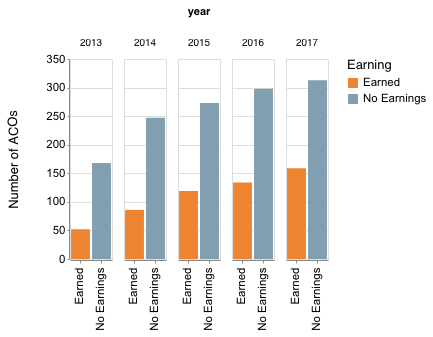

In [5]:
bars = alt.Chart(data_to_chart).mark_bar().encode(
    x=alt.X('Earning:N',axis=alt.Axis(title='')),
    column='year:O',
    y=alt.Y('ACO_Name:Q', axis=alt.Axis(title='Number of ACOs')),
    color='Earning:N'
)
bars

## Adding Risk Adjustment

In one of the steps above, we calculated with average HCC Risk scores of earners and the non-earners. THis next cell will add that to the chart. 

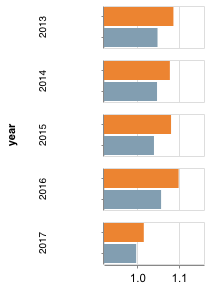

In [6]:
risk_scores = alt.Chart(data_to_chart,
                    width=100).mark_bar().encode(
    x=alt.X('ACO_WGHT_HCC_AVG:Q',axis=alt.Axis(title='')
           ,scale=alt.Scale(domain=(.925,1.15))),
    row='year:O',
    y=alt.Y('Earning:N', axis=alt.Axis(title='', labels=False)),
    color=alt.Color('Earning:N', legend=None)
)

risk_scores